In [1]:
from ecnet.datasets import load_cn, load_lhv

smiles_cn, cn = load_cn()
smiles_lhv, lhv = load_lhv()

data_cn = []
data_lhv = []
smiles = []

for idx_cn, smi_cn in enumerate(smiles_cn):
    for idx, smi in enumerate(smiles_lhv):
        if smi_cn == smi:
            data_cn.append(cn[idx_cn])
            data_lhv.append(lhv[idx])
            smiles.append(smi_cn)
            break

print(len(data_cn), len(data_lhv), len(smiles))

77 77 77


In [2]:
from sklearn.preprocessing import StandardScaler

scaler_cn = StandardScaler()
scaler_lhv = StandardScaler()
scaler_cn.fit(data_cn)
scaler_lhv.fit(data_lhv)
data_cn = scaler_cn.transform(data_cn)
data_lhv = scaler_lhv.transform(data_lhv)

print(min(data_cn), max(data_cn))
print(min(data_lhv), max(data_lhv))

[-1.14043184] [3.18646595]
[-2.64439138] [1.26098293]


In [3]:
from sklearn.model_selection import train_test_split

smiles_train, smiles_test, cn_train, cn_test, lhv_train, lhv_test = train_test_split(smiles, data_cn, data_lhv, test_size=0.25, random_state=0)

print(len(smiles_train), len(smiles_test))

57 20


In [4]:
###############
### CN ONLY ###
###############

from ecnet.datasets import QSPRDataset

ds_train = QSPRDataset(smiles_train, cn_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

In [5]:
from sklearn.decomposition import PCA
import torch

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([57, 57]) torch.Size([20, 57])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/3723054795.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/3723054795.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 72.45811221474095 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.29794808673231227 | Valid loss: 0.509660542011261
Epoch: 50 | Train loss: 0.05358018976097044 | Valid loss: 0.07437475770711899
Epoch: 75 | Train loss: 0.018718035156397445 | Valid loss: 0.010461864061653614
Epoch: 100 | Train loss: 0.014730462020165041 | Valid loss: 0.10213994234800339
Epoch: 125 | Train loss: 0.005741079276623695 | Valid loss: 0.0040555913001298904
Epoch: 150 | Train loss: 0.003260986438315166 | Valid loss: 0.0027856293600052595
Epoch: 175 | Train loss: 0.0031939373278108084 | Valid loss: 0.0046168179251253605
Epoch: 200 | Train loss: 0.0017888229340314865 | Valid loss: 0.0017326909583061934


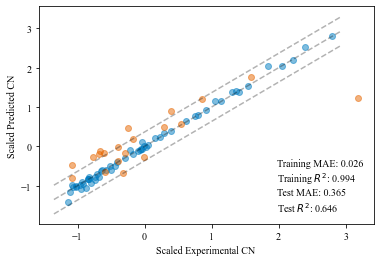

In [6]:
from ecnet import ECNet
from sklearn.metrics import median_absolute_error, r2_score
from matplotlib import pyplot as plt
from matplotlib.offsetbox import AnchoredText

model_cn = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_cn.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_cn(ds_train.desc_vals).detach().numpy()
pred_test = model_cn(ds_test.desc_vals).detach().numpy()

mae_train = median_absolute_error(cn_train, pred_train)
mae_test = median_absolute_error(cn_test, pred_test)

r2_train = r2_score(cn_train, pred_train)
r2_test = r2_score(cn_test, pred_test)

min_val = min(min(pred_train), min(cn_train)) - 0.05 * min(min(pred_train), min(cn_train))
max_val = max(max(pred_train), max(cn_train)) + 0.05 * max(max(pred_train), max(cn_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental CN')
plt.ylabel('Scaled Predicted CN')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--', alpha=0.3)
plt.scatter(cn_train, pred_train, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(cn_test, pred_test, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train, r2_train, mae_test, r2_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()


In [7]:
################
### LHV ONLY ###
################

ds_train = QSPRDataset(smiles_train, lhv_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, lhv_test, backend='alvadesc')

In [8]:
pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([57, 57]) torch.Size([20, 57])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/2641696615.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/2641696615.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 136.08535766601562 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.24776904677089892 | Valid loss: 0.4464385509490967
Epoch: 50 | Train loss: 0.030281964591459223 | Valid loss: 0.04916128143668175
Epoch: 75 | Train loss: 0.019229082905344273 | Valid loss: 0.03010334074497223
Epoch: 100 | Train loss: 0.014195064716898886 | Valid loss: 0.019482137635350227
Epoch: 125 | Train loss: 0.005711402302901996 | Valid loss: 0.007577879820019007
Epoch: 150 | Train loss: 0.007661943152350814 | Valid loss: 0.0084264250472188
Epoch: 175 | Train loss: 0.005803305949819715 | Valid loss: 0.004209373611956835
Epoch: 200 | Train loss: 0.0025989727950409837 | Valid loss: 0.0013284141896292567
Epoch: 225 | Train loss: 0.004195131343103161 | Valid loss: 0.005244097206741571
Epoch: 250 | Train loss: 0.0046702268484391666 | Valid loss: 0.004790848586708307


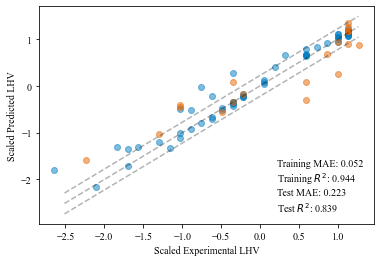

In [9]:
model_lhv = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_lhv.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_lhv(ds_train.desc_vals).detach().numpy()
pred_test = model_lhv(ds_test.desc_vals).detach().numpy()

mae_train = median_absolute_error(lhv_train, pred_train)
mae_test = median_absolute_error(lhv_test, pred_test)

r2_train = r2_score(lhv_train, pred_train)
r2_test = r2_score(lhv_test, pred_test)

min_val = min(min(pred_train), min(lhv_train)) - 0.05 * min(min(pred_train), min(lhv_train))
max_val = max(max(pred_train), max(lhv_train)) + 0.05 * max(max(pred_train), max(lhv_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental LHV')
plt.ylabel('Scaled Predicted LHV')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test, max_val + mae_test], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test, max_val - mae_test], 'k--', alpha=0.3)
plt.scatter(lhv_train, pred_train, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(lhv_test, pred_test, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train, r2_train, mae_test, r2_test
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

In [10]:
###################
### YSI and LHV ###
###################

import numpy as np

targets_train = np.concatenate((np.array(cn_train), np.array(lhv_train)), axis=1)
targets_test = np.concatenate((np.array(cn_test), np.array(lhv_test)), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, targets_test, backend='alvadesc')

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)
print(ds_train.target_vals.shape, ds_test.target_vals.shape)

torch.Size([57, 5305]) torch.Size([20, 5305])
torch.Size([57, 2]) torch.Size([20, 2])


In [11]:
pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

print(ds_train.desc_vals.shape, ds_test.desc_vals.shape)

torch.Size([57, 57]) torch.Size([20, 57])


/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/2641696615.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/2641696615.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Epoch: 0 | Train loss: 150.57905819541529 | Valid loss: 9223372036854775807
Epoch: 25 | Train loss: 0.5381967393975509 | Valid loss: 0.605359673500061
Epoch: 50 | Train loss: 0.08800130690398969 | Valid loss: 0.08670662343502045
Epoch: 75 | Train loss: 0.02969846756834733 | Valid loss: 0.037826426327228546
Epoch: 100 | Train loss: 0.02901153658565722 | Valid loss: 0.028521757572889328
Epoch: 125 | Train loss: 0.007675009583564181 | Valid loss: 0.0079384446144104
Epoch: 150 | Train loss: 0.003308559816918875 | Valid loss: 0.0034273832570761442
Epoch: 175 | Train loss: 0.0015430669974241602 | Valid loss: 0.0007267217733897269
Epoch: 200 | Train loss: 0.0005596491177321264 | Valid loss: 0.000435791997006163
Epoch: 225 | Train loss: 0.0003493096477254049 | Valid loss: 0.00023359876649919897
Epoch: 250 | Train loss: 0.0004961336564615761 | Valid loss: 0.0002796348126139492
Epoch: 275 | Train loss: 0.00018441883232873422 | Valid loss: 0.00010295469837728888
Epoch: 300 | Train loss: 0.0002404

/Users/tjkessler/anaconda3/envs/ecnet/lib/python3.8/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


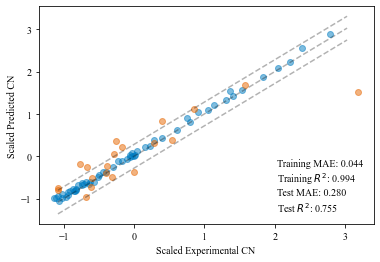

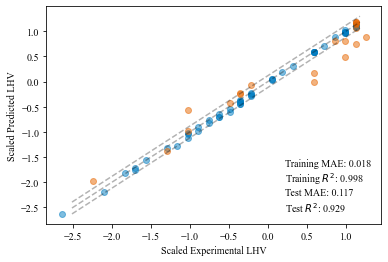

In [12]:
model_multi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
model_multi.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=25, lr=0.001)

pred_train = model_multi(ds_train.desc_vals).detach().numpy()
pred_test = model_multi(ds_test.desc_vals).detach().numpy()

pred_train_cn = [p[0] for p in pred_train]
pred_train_lhv = [p[1] for p in pred_train]
pred_test_cn = [p[0] for p in pred_test]
pred_test_lhv = [p[1] for p in pred_test]

mae_train_ysi = median_absolute_error(cn_train, pred_train_cn)
mae_train_lhv = median_absolute_error(lhv_train, pred_train_lhv)
mae_test_ysi = median_absolute_error(cn_test, pred_test_cn)
mae_test_lhv = median_absolute_error(lhv_test, pred_test_lhv)

r2_train_cn = r2_score(cn_train, pred_train_cn)
r2_train_lhv = r2_score(lhv_train, pred_train_lhv)
r2_test_cn = r2_score(cn_test, pred_test_cn)
r2_test_lhv = r2_score(lhv_test, pred_test_lhv)

min_val = min(min(pred_train_cn), min(cn_train)) - 0.05 * min(min(pred_train_cn), min(cn_train))
max_val = max(max(pred_train_cn), max(cn_train)) + 0.05 * max(max(pred_train_cn), max(cn_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental CN')
plt.ylabel('Scaled Predicted CN')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test_ysi, max_val + mae_test_ysi], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test_ysi, max_val - mae_test_ysi], 'k--', alpha=0.3)
plt.scatter(cn_train, pred_train_cn, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(cn_test, pred_test_cn, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train_ysi, r2_train_cn, mae_test_ysi, r2_test_cn
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

min_val = min(min(pred_train_lhv), min(lhv_train)) - 0.05 * min(min(pred_train_lhv), min(lhv_train))
max_val = max(max(pred_train_lhv), max(lhv_train)) + 0.05 * max(max(pred_train_lhv), max(lhv_train))

plt.clf()
plt.rcParams['font.family'] = 'Times New Roman'
plt.xlabel('Scaled Experimental LHV')
plt.ylabel('Scaled Predicted LHV')
plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val + mae_test_lhv, max_val + mae_test_lhv], 'k--', alpha=0.3)
plt.plot([min_val, max_val], [min_val - mae_test_lhv, max_val - mae_test_lhv], 'k--', alpha=0.3)
plt.scatter(lhv_train, pred_train_lhv, label='Training Set', color=(0, 114/235, 178/235), alpha=0.5)
plt.scatter(lhv_test, pred_test_lhv, label='Test Set', color=(213/235, 94/235, 0), alpha=0.5)
string = 'Training MAE: {:.3f}\nTraining $R^2$: {:.3f}\nTest MAE: {:.3f}\nTest $R^2$: {:.3f}'.format(
    mae_train_lhv, r2_train_lhv, mae_test_lhv, r2_test_lhv
)
text_box = AnchoredText(string, frameon=True, loc=4, pad=0.5)
plt.setp(text_box.patch, facecolor='white', edgecolor='white', alpha=0.0)
plt.gca().add_artist(text_box)
plt.show()

In [13]:
##########################
### 25 trials, JUST CN ###
##########################

ds_train = QSPRDataset(smiles_train, cn_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train = []
maes_test = []
r2s_train = []
r2s_test = []

for _ in range(25):

    model_cn = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_cn.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_cn(ds_train.desc_vals).detach().numpy()
    pred_test = model_cn(ds_test.desc_vals).detach().numpy()

    maes_train.append(median_absolute_error(cn_train, pred_train))
    maes_test.append(median_absolute_error(cn_test, pred_test))

    r2s_train.append(r2_score(cn_train, pred_train))
    r2s_test.append(r2_score(cn_test, pred_test))

print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train), np.std(maes_train)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train), np.std(r2s_train)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test), np.std(maes_test)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test), np.std(r2s_test)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/154747349.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/154747349.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Training set MAE: 0.046 +/- 0.050
Training set R2: 0.968 +/- 0.073
Test set MAE: 0.271 +/- 0.058
Test set R2: 0.709 +/- 0.062


In [14]:
###########################
### 25 trials, JUST LHV ###
###########################

ds_train = QSPRDataset(smiles_train, lhv_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, lhv_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train = []
maes_test = []
r2s_train = []
r2s_test = []

for _ in range(25):

    model_lhv = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_lhv.fit(dataset=ds_train, epochs=512, valid_size=0.33, shuffle=True, patience=64, verbose=0, lr=0.001)

    pred_train = model_lhv(ds_train.desc_vals).detach().numpy()
    pred_test = model_lhv(ds_test.desc_vals).detach().numpy()

    maes_train.append(median_absolute_error(lhv_train, pred_train))
    maes_test.append(median_absolute_error(lhv_test, pred_test))

    r2s_train.append(r2_score(lhv_train, pred_train))
    r2s_test.append(r2_score(lhv_test, pred_test))

print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train), np.std(maes_train)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train), np.std(r2s_train)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test), np.std(maes_test)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test), np.std(r2s_test)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/260997071.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/260997071.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


Training set MAE: 0.058 +/- 0.097
Training set R2: 0.951 +/- 0.189
Test set MAE: 0.153 +/- 0.094
Test set R2: 0.878 +/- 0.063


In [15]:
##############################
### 25 trials, LHV and YSI ###
##############################

targets_train = np.concatenate((np.array(cn_train), np.array(lhv_train)), axis=1)
targets_test = np.concatenate((np.array(cn_test), np.array(lhv_test)), axis=1)

ds_train = QSPRDataset(smiles_train, targets_train, backend='alvadesc')
ds_test = QSPRDataset(smiles_test, cn_test, backend='alvadesc')

pca = PCA(len(ds_train))
pca.fit(ds_train.desc_vals.detach().numpy())
ds_train.desc_vals = torch.tensor(pca.transform(ds_train.desc_vals.detach().numpy())).type(torch.float32)
ds_test.desc_vals = torch.tensor(pca.transform(ds_test.desc_vals.detach().numpy())).type(torch.float32)

ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)

maes_train_cn = []
maes_train_lhv = []
maes_test_cn = []
maes_test_lhv = []
r2s_train_cn = []
r2s_train_lhv = []
r2s_test_cn = []
r2s_test_lhv = []

for _ in range(25):

    model_multi = ECNet(ds_train.desc_vals.shape[1], ds_train.target_vals.shape[1], 512, 2)
    model_multi.fit(dataset=ds_train, epochs=256, valid_size=0.33, shuffle=True, patience=32, verbose=0, lr=0.001)

    pred_train = model_multi(ds_train.desc_vals).detach().numpy()
    pred_test = model_multi(ds_test.desc_vals).detach().numpy()
    pred_train_cn = [p[0] for p in pred_train]
    pred_train_lhv = [p[1] for p in pred_train]
    pred_test_cn = [p[0] for p in pred_test]
    pred_test_lhv = [p[1] for p in pred_test]

    maes_train_cn.append(median_absolute_error(cn_train, pred_train_cn))
    maes_train_lhv.append(median_absolute_error(lhv_train, pred_train_lhv))
    maes_test_cn.append(median_absolute_error(cn_test, pred_test_cn))
    maes_test_lhv.append(median_absolute_error(lhv_test, pred_test_lhv))

    r2s_train_cn.append(r2_score(cn_train, pred_train_cn))
    r2s_train_lhv.append(r2_score(lhv_train, pred_train_lhv))
    r2s_test_cn.append(r2_score(cn_test, pred_test_cn))
    r2s_test_lhv.append(r2_score(lhv_test, pred_test_lhv))

print('CN:')
print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train_cn), np.std(maes_train_cn)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train_cn), np.std(r2s_train_cn)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test_cn), np.std(maes_test_cn)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test_cn), np.std(r2s_test_cn)))
print('\nLHV:')
print('Training set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_train_lhv), np.std(maes_train_lhv)))
print('Training set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_train_lhv), np.std(r2s_train_lhv)))
print('Test set MAE: {:.3f} +/- {:.3f}'.format(np.mean(maes_test_lhv), np.std(maes_test_lhv)))
print('Test set R2: {:.3f} +/- {:.3f}'.format(np.mean(r2s_test_lhv), np.std(r2s_test_lhv)))

/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/151319245.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_train.target_vals = torch.tensor(ds_train.target_vals).type(torch.float32)
/var/folders/p2/sy4mm_hj0bv50k91q64hd9rh0000gn/T/ipykernel_55911/151319245.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ds_test.target_vals = torch.tensor(ds_test.target_vals).type(torch.float32)


CN:
Training set MAE: 0.101 +/- 0.090
Training set R2: 0.932 +/- 0.100
Test set MAE: 0.304 +/- 0.100
Test set R2: 0.658 +/- 0.134

LHV:
Training set MAE: 0.084 +/- 0.069
Training set R2: 0.946 +/- 0.076
Test set MAE: 0.188 +/- 0.094
Test set R2: 0.870 +/- 0.073
